# Machine Learning for Employee satisfaction

Upon completion of the previous steps for the HR department trying to predit if an employee leaves the company or not, which includes `EDA` and regression analysis `Logistic Regression`. It is now time to predict if a customer leaves the company or is retained using `machine learning models`.

In [1]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

# For saving models
import pickle

In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv(r'C:\Users\user\Desktop\Course 7\HR_capstone_dataset.csv')

# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# Display basic information
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Display basic stats
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
# Rename columns as needed
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department',
                         'number_project': 'project_number'})

# Display all column names after the update
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'project_number',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [6]:
# Check missing values
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
project_number           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [7]:
# Check for duplicates
duplicate=df0.duplicated().sum()

In [8]:
duplicate

3008

In [13]:
# make a copy of the original data
df1= df0.copy()

# Drop duplicates and save resulting dataframe in a new variable as needed
df1= df1.drop_duplicates(keep= 'first')

# Print the number of rows and coumns
print(df1.shape)

# Display first few rows
(df1.head(5))

(11991, 10)


,satisfaction_level,last_evaluation,project_number,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Model Preparation

In [15]:
# Copy the dataframe
df_enc = df1.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
print(df_enc.shape)
df_enc.head()

(11991, 19)


,satisfaction_level,last_evaluation,project_number,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


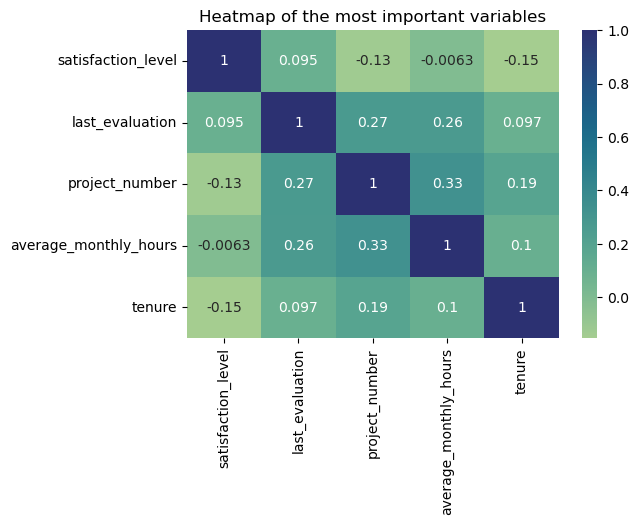

In [19]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(6, 4))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'project_number', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the most important variables')
plt.show()

In [20]:
# Determine the number of rows containing outliers 

# Compute the 25th percentile value in `tenure`
percentile25= df1['tenure'].quantile(0.25)

# Compute the 75th percentile value in `tenure`
percentile75= df1['tenure'].quantile(0.75)

# Compute the interquartile range in `tenure`
iqr= percentile75- percentile25

upper_limit= percentile75 + 1.5*iqr
lower_limit= percentile25 - 1.5*iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `tenure`
outliers = df1[(df1['tenure']> upper_limit) | (df1['tenure'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


**Note:** If it were a regression model building, we might be concerned with dropping the outliers, or creating a new dataframe that does not include the above outlier values. But because we are building a tree-based model which is robust to outliers, we would leave it and see how the model performs.

# Tree based model

### Build a decision tree

In [22]:
# Isolate the outcome variable
y = df_enc['left']

In [27]:
# Isolate the predictor variables
X= df_enc.drop(['left'], axis=1 )

# Display first few rows
X.head()

,satisfaction_level,last_evaluation,project_number,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision tree - Round 1

Construct a decision tree model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [38]:
# Instantiate the model
tree= DecisionTreeClassifier(random_state= 0)

# Assign a dictionary of hyperparameters to search over
cv_params= {'max_depth':[4,6,8, None],
            'min_samples_leaf':[2,5,1],
            'min_samples_split': [2,4,6],
           }

# Assign a dictionary of scoring metrics to capture
scoring= {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1= GridSearchCV(tree, cv_params, scoring= scoring, cv=5, refit='roc_auc')

In [39]:
%%time

# Fit the model to the training set
tree1.fit(X_train, y_train)

CPU times: total: 6.78 s
Wall time: 10 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'precision', 'roc_auc', 'f1', 'accuracy', 'recall'})

Identify the optimal values for the decision tree parameters.

In [40]:
# Check best parameters
tree1.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}

Identify the best AUC score achieved by the decision tree model on the training set.

In [42]:
tree1.best_score_

0.9719548921460799

This is a strong AUC score, which shows that this model can predict employees who will leave very well.

Next, we can write a function that will help extract all the scores from the grid search. 

In [43]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what we want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

Use the function just defined to get all the scores from grid search.


In [44]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.972227,0.914269,0.942307,0.98143,0.971955


All of these scores from the decision tree model are very strong indicators of good model performance. 

Recall that decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions. We could construct a random forest model next.

#### Random forest - Round 1

In [46]:
# Instantiate the model
rf= RandomForestClassifier(random_state= 0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='roc_auc')

In [47]:
%%time
# Fit the random forest model to the training data.
rf1.fit(X_train, y_train)

CPU times: total: 35min 54s
Wall time: 1h 56min 46s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'precision', 'roc_auc', 'f1', 'accuracy', 'recall'})

Identify the best AUC score achieved by the random forest model on the training set.

In [48]:
# Check best AUC score on CV
rf1.best_score_

0.9804250949807172

Identify the optimal values for the parameters of the random forest model.

In [49]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

Collect the evaluation scores on the training set for the decision tree and random forest models.

In [51]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.972227  0.914269  0.942307   0.98143  0.971955
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


**Note:**

The evaluation scores of the random forest model are slightly lower than those of the decision tree model for some metrics, but we will stick to the random forest model because it is less prone to overfitting, and it tuned more hyperparameters compare to the decision tree. 

Next, we can evaluate the final model on the test set.

##### Define a function that gets all the scores from a model's predictions.

In [52]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How we want the model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [53]:
# Get predictions on test data using random forest
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.964211,0.919679,0.941418,0.980987,0.956439


In [54]:
# Get predictions on test data using decision tree
tree_test_scores= get_scores('Decision_tree_test', tree1, X_test, y_test)
tree_test_scores

,model,precision,recall,f1,accuracy,AUC
0,Decision_tree_test,0.972399,0.919679,0.945304,0.982322,0.957239


**Quick Insight**

The test scores are very similar to the validation scores on the train data, which is good. This appears to be a strong model. Since this test set was only used for this model, we can be more confident that the model's performance on this data is representative of how it will perform on new, unseeen data. It is worth noting that decision tree gave better results compared to the random forest, but since the difference is not significant, we can move to some `feature engineering.`

**Feature engineering**

We might be skeptical of the high evaluation scores. There is a chance that there is some data leakage occurring. `Data leakage` is when we use data to train your model that should not be used during training, either because it appears in the test data or because it's not data that we would expect to have when the model is actually deployed. Training a model with leaked data can give an unrealistic score that is not replicated in production.

In this case, it's likely that the company won't have satisfaction levels reported for all of its employees. It's also possible that the `average_monthly_hours` column is a source of some data leakage. If employees have already decided upon quitting, or have already been identified by management as people to be fired, they may be working fewer hours. 

The first round of decision tree and random forest models included all variables as features. This next round will incorporate feature engineering to build improved models. 

We could proceed by dropping `satisfaction_level` and creating a new feature that roughly captures whether an employee is overworked. We will call this new feature `overworked`. It will be a binary variable.

In [81]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
df2 = df_enc.drop('satisfaction_level', axis=1)

# Display first few rows of new dataframe
df2.head()

,last_evaluation,project_number,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [74]:
# Create `overworked` column. For now, it's identical to average monthly hours.
df2['overworked'] = df2['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


In [63]:
df2['overworked'].mean()

200.4735218080227

166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day, but we observed that the mean working hour in the dataset is 200.5 hours

We could define being overworked as working more than 175 hours per month on average.

To make the `overworked` column binary, we could reassign the column using a boolean mask.
- `df3['overworked'] > 175` creates a series of booleans, consisting of `True` for every value > 175 and `False` for every values ≤ 175
- `.astype(int)` converts all `True` to `1` and all `False` to `0` 

In [84]:
# Define `overworked` as working > 175 hrs/week
df2['overworked'] = (df2['average_monthly_hours'] > 175).astype(bool)

# Display first few rows of new column
df2['overworked'].head()

0    False
1     True
2     True
3     True
4    False
Name: overworked, dtype: bool

In [85]:
# Convert overworked column to binary, where 1 denotes overworked, and 0 denotes underworked
df2['overworked']= df2['overworked'].astype(int)

# Display first few rows
df2.head()

,last_evaluation,project_number,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


Drop the `average_monthly_hours` column.

In [89]:
# Drop the `average_monthly_hours` column
df2 = df2.drop('average_monthly_hours', axis=1)
df2.head()

,last_evaluation,project_number,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0.88,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.87,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


Again, isolate the features and target variables

In [90]:
# Isolate the outcome variable
y = df2['left']

# Select the features
X = df2.drop('left', axis=1)

Split the data into training and testing sets.

In [91]:
# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

### Decision tree - Round 2

In [92]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [93]:
%%time
tree2.fit(X_train, y_train)

CPU times: total: 5.34 s
Wall time: 6.63 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'precision', 'roc_auc', 'f1', 'accuracy', 'recall'})

In [94]:
# Check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [95]:
# Check best AUC score on CV
tree2.best_score_

0.9586752505340426

This model performs very well, even without satisfaction levels and detailed hours worked data. 

Next, check the other scores.

In [96]:
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.972227  0.914269  0.942307   0.98143  0.971955
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

### Random forest - Round 2

In [97]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [98]:
%%time
rf2.fit(X_train, y_train)

CPU times: total: 28min 11s
Wall time: 31min 11s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'precision', 'roc_auc', 'f1', 'accuracy', 'recall'})

In [99]:
# Check best params
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [100]:
# Check best AUC score on CV
rf2.best_score_

0.9648100662833985

In [105]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(rf1_cv_results)
print(rf2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


Again, the scores dropped slightly, but the random forest performs better than the decision tree if using AUC as the deciding metric. 

Score the rf2 model on the test set now.

In [106]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.870406,0.903614,0.8867,0.961641,0.938407


This seems to be a stable, well-performing final model. 

Plot a confusion matrix to visualize how well it predicts on the test set.

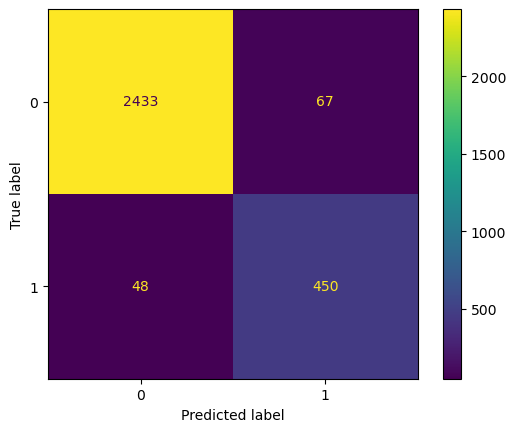

In [108]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot();

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of leaving the company, or getting fired when that's actually not the case. But this is still a strong model.

For exploratory purpose, we might want to inspect the splits of the decision tree model and the most important features in the random forest model used. 

### Decision tree splits

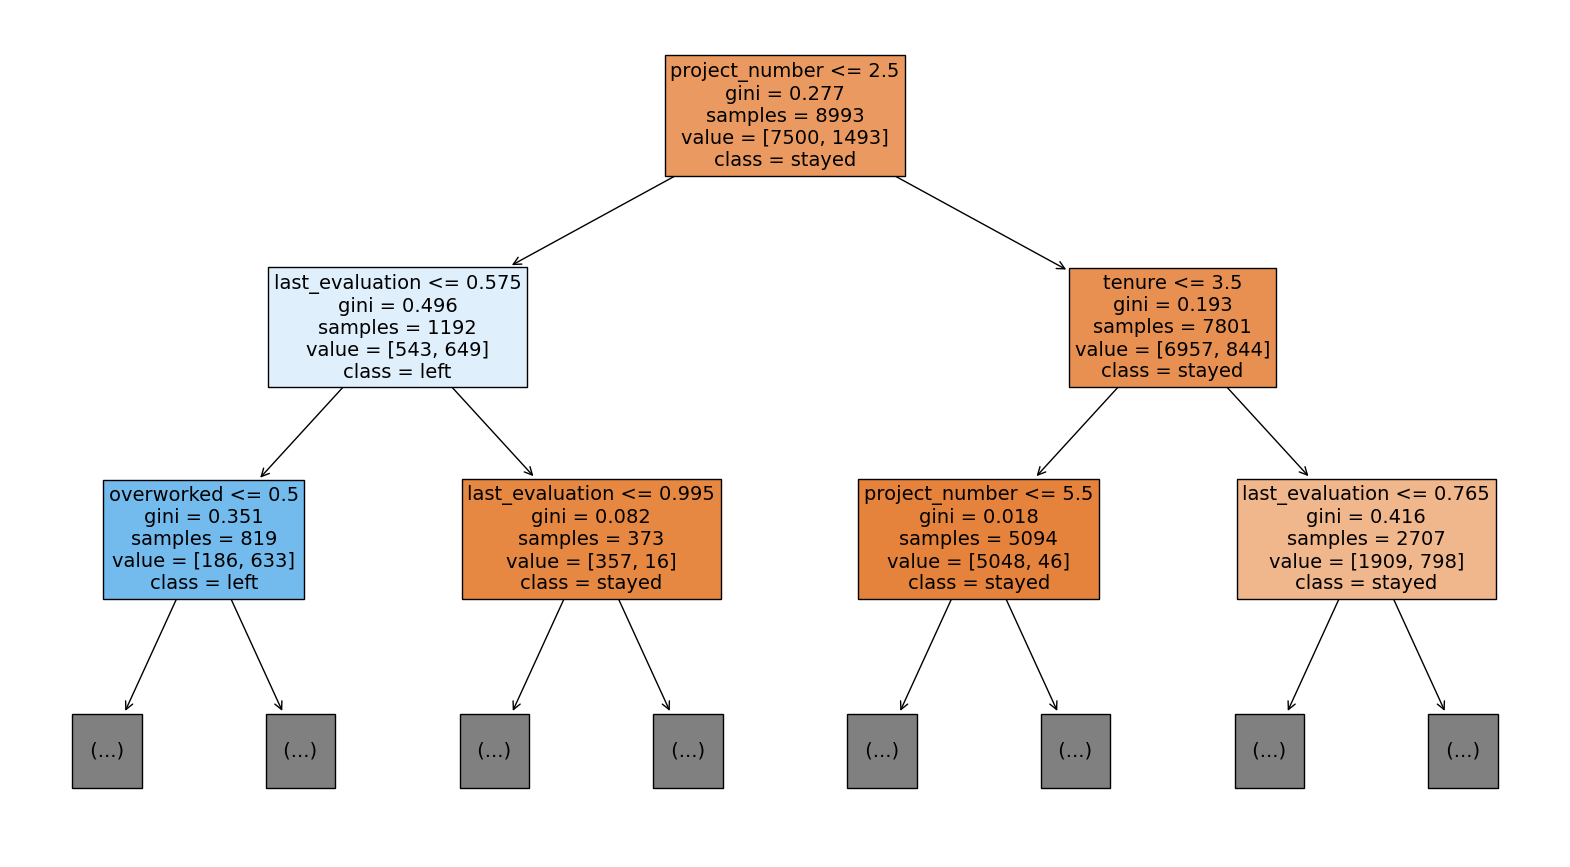

In [116]:
# Plot the tree
plt.figure(figsize=(20, 11))
plot_tree(tree2.best_estimator_, max_depth=2, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

#### Random forest feature importance

Now, plot the feature importances for the random forest model.

<Figure size 500x300 with 0 Axes>

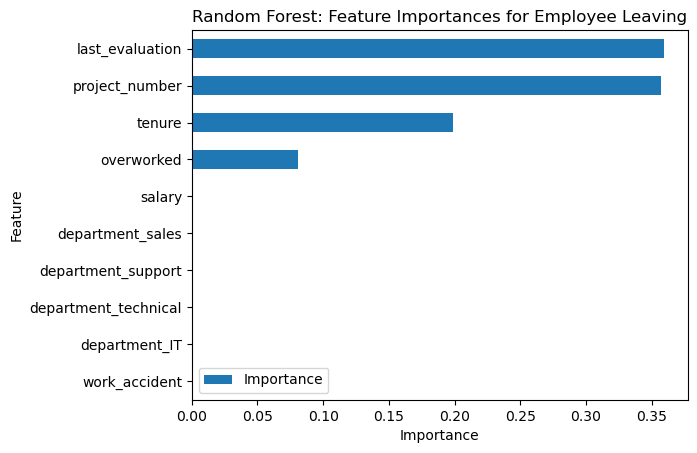

In [124]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot()

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, `last_evaluation`, `project_number`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`, and they are the same as the ones used by the decision tree model.

# pacE: Execute Stage
- Interpret model performance and results
- Share actionable steps with stakeholders




## Recall evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example. 
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.

### Summary of model results

**Logistic Regression**

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

**Tree-based Machine Learning**

After conducting feature engineering, the decision tree model achieved AUC of 93.8%, precision of 87.0%, recall of 90.4%, f1-score of 88.7%, and accuracy of 96.2%, on the test set. The decision tree also performend relatively well also.

# Conclusion, Recommendations, Next Steps

The models and the feature importances extracted from the models confirm that employees at the company are overworked. 

To retain employees, the following recommendations could be presented to the stakeholders:

**My findings to stakeholders, which is the HR team**
* Cap the number of projects that employees can work on.
* Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied. 
* Either reward employees for working longer hours, or don't require them to do so. 
* If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear. 
* Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts. 
* High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort. 

**Next Steps**

It may be justified to still have some concern about data leakage. It could be prudent to consider how predictions change when `last_evaluation` is removed from the data. It's possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature. It's also possible that the evaluation score determines whether an employee leaves or stays, in which case it could be useful to pivot and try to predict performance score. The same could be said for satisfaction score. 
